In [1]:
# !pip install perceval-quandela

In [2]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm

In [3]:
nphotons = 4
#

In [4]:
# Differential equation parameters

def F_E1(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return X_prime+Y_prime+2*X+Y

def F_E2(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return Y_prime+5*X+3*Y

In [5]:
# Boundary condition 
X_0 = 0
Y_0 = 1
X_0 = 2.6885377567769764
Y_0 = -3.790585633545575

In [6]:
# Modeling parameters
n_grid = 50    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 1  # maximum of the interval on which we wish to approximate our function
T = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [7]:
# Differential equation's exact solution - for comparison
# def u(x):
#     return 0.5*np.log((x+1)/(x-1))

def X_t(t):
    return X_0*np.cos(t)+(3*X_0+2*Y_0)*np.sin(t)

def Y_t(t):
    return Y_0*np.cos(t)-(3*Y_0+5*X_0)*np.sin(t)

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt

# X_0 = 0
# Y_0 = 1

# def X_t(t):
#     return X_0 * np.cos(t) + (3 * X_0 + 2 * Y_0) * np.sin(t)

# def Y_t(t):
#     return Y_0 * np.cos(t) - (3 * Y_0 + 5 * X_0) * np.sin(t)

# # Generate an array of values for t
# t_values = np.linspace(0, 2 * np.pi, 100)

# # Compute the corresponding values of X_t and Y_t
# X_values = X_t(t_values)
# Y_values = Y_t(t_values)

# # Plot X_t and Y_t
# plt.plot(t_values, X_values, label='X_t')
# plt.plot(t_values, Y_values, label='Y_t')

# # Add labels and a legend
# plt.xlabel('t')
# plt.ylabel('Function Value')
# plt.legend()

# # Show the plot
# plt.show()


In [9]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dt = (range_max-range_min) / (n_grid - 1)

In [10]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1>


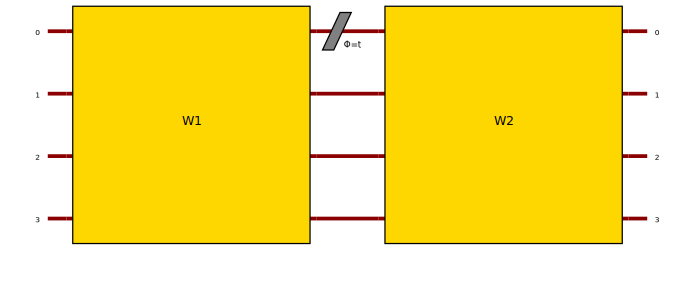

In [11]:
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=2*4*m**2)
params_E1 = parameters[:4*m**2]
params_E2 = parameters[4*m**2:]
# parameters_E1 = np.random.normal(size=4*m**2)
# parameters_E2 = np.random.normal(size=4*m**2)


pt_t = pcvl.P("t")


c_E1 = pcvl.Unitary(pcvl.Matrix.random_unitary(m, params_E1[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(pt_t))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, params_E1[2 * m ** 2:]), name="W2")


c_E2 = pcvl.Unitary(pcvl.Matrix.random_unitary(m, params_E2[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(pt_t))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, params_E2[2 * m ** 2:]), name="W2")

simulator_backend_1 = pcvl.BackendFactory().get_backend("SLOS")
s1 = simulator_backend_1(pcvl.Matrix.random_unitary(m))
s1.compile(input_state)

simulator_backend_2 = pcvl.BackendFactory().get_backend("SLOS")
s2 = simulator_backend_2(pcvl.Matrix.random_unitary(m))
s2.compile(input_state)

pcvl.pdisplay(c_E1)

In [12]:
def computation(params):
    global current_loss
    global computation_count
    "compute the loss function of a given differential equation in order for it to be optimized"
    computation_count += 1


    #params seperation
    params_E1 = params[:4*m**2]
    params_E2 = params[4*m**2:]



    # boundary condition X_0
    X_theta_0 = 0  
    coefs = lambda_random  # coefficients of the M observable
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params_E1[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, params_E1[2 * m ** 2:])

    pt = pcvl.P("t")
    c_E1 = pcvl.Unitary(U_2) // (0, pcvl.PS(pt)) // pcvl.Unitary(U_1)

    pt.set_value(np.pi * X_0)
    U = c_E1.compute_unitary(use_symbolic=False)
    s1.U = U
    X_theta_0 = np.sum(np.multiply(s1.all_prob(input_state), coefs))

    # boundary condition Y_0
    Y_theta_0 = 0  
    coefs = lambda_random  # coefficients of the M observable
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params_E2[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, params_E2[2 * m ** 2:])

    # pt = pcvl.P("t")
    c_E2 = pcvl.Unitary(U_2) // (0, pcvl.PS(pt)) // pcvl.Unitary(U_1)

    pt.set_value(np.pi * Y_0)
    U = c_E2.compute_unitary(use_symbolic=False)
    s2.U = U
    Y_theta_0 = np.sum(np.multiply(s2.all_prob(input_state), coefs))



    # boundary condition given a weight eta
    loss = eta * (X_theta_0 - X_0) ** 2 * len(T)
    loss += eta * (Y_theta_0 - Y_0) ** 2 * len(T)
    # loss=0

    # X[0] is before the domain we are interested in (used for differentiation), t0 is at X[1]
    X = np.zeros(n_grid + 2)

    # Y[0] is before the domain we are interested in (used for differentiation), t0 is at Y[1]
    Y = np.zeros(n_grid + 2)

    # t0 is at the beginning of the domain, already calculated
    X[1] = X_theta_0
    Y[1] = Y_theta_0


    pt.set_value(np.pi * (range_min - dt))
    s1.U = c_E1.compute_unitary(use_symbolic=False)
    X[0] = np.sum(np.multiply(s1.all_prob(input_state), coefs))

    s2.U = c_E2.compute_unitary(use_symbolic=False)
    Y[0] = np.sum(np.multiply(s2.all_prob(input_state), coefs))

    for i in range(1, n_grid):
        t = T[i]
        pt.set_value(np.pi * t)
        s1.U = c_E1.compute_unitary(use_symbolic=False)
        X[i + 1] = np.sum(np.multiply(s1.all_prob(input_state), coefs))
        s2.U = c_E2.compute_unitary(use_symbolic=False)
        Y[i + 1] = np.sum(np.multiply(s2.all_prob(input_state), coefs))

    pt.set_value(np.pi * (range_max + dt))
    s1.U = c_E1.compute_unitary(use_symbolic=False)
    X[n_grid + 1] = np.sum(np.multiply(s1.all_prob(input_state), coefs))
    s2.U = c_E2.compute_unitary(use_symbolic=False)
    Y[n_grid + 1] = np.sum(np.multiply(s2.all_prob(input_state), coefs))


    # Differentiation
    X_prime = (X[2:] - X[:-2])/(2*dt)
    Y_prime = (Y[2:] - Y[:-2])/(2*dt)

    loss += np.sum((F_E1(X_prime, X[1:-1],Y_prime,Y[1:-1], T))**2)
    loss += np.sum((F_E2(X_prime, X[1:-1],Y_prime,Y[1:-1], T))**2)


    current_loss = loss / (2*len(T))

    return current_loss

In [13]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    global best_param_temp
    
    best_param_temp = parameters
    now = time.time()
    pbar.set_description("M= %d Loss: %0.5f #computations: %d elapsed: %0.5f" %
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    computation_count = 0
    start_time = now
    # np.save(file=str(np.random.random())+'('+str(nphotons)+')'+'_params1.ipy',arr=parameters)

In [14]:
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []
best_param_temp = None

pbar = tqdm.tqdm()
res = minimize(computation, parameters, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

M= 4 Loss: 0.22416 #computations: 258 elapsed: 12.74078: : 887it [2:26:51, 14.72s/it]

In [15]:
# print("Unitary parameters", best_param_temp)
# np.save(file=str(np.random.random())+'('+str(nphotons)+')'+'_params1.ipy',arr=best_param_temp)

In [16]:
print("Unitary parameters", res.x)
np.save(file=str(np.random.random())+'('+str(nphotons)+')'+'_params1.ipy',arr=res.x)


Unitary parameters [-3.67135948e-01  1.40153072e-01 -3.34091356e+00  5.42247548e+00
 -3.94715828e-01  3.86594025e-01 -1.08355398e+00  7.64043532e+00
 -2.33832972e-01  2.22753310e-01 -3.61439368e+00 -1.19075443e+00
  1.83125615e+00 -2.26654834e+00  1.72187145e+00  4.81296649e+00
 -1.40556561e-01  5.89901133e-01  1.77770515e-01  6.44865055e+00
  4.08176420e-02  1.53751155e-01  2.27191075e+00 -3.73730299e-01
  3.30100397e-01 -4.84930387e-02  6.22816733e+00 -3.73621401e+00
 -2.34350525e+00  8.27135181e-01  4.28879848e-01  6.72939440e+00
  2.91088292e+00  9.43086917e-01  2.09621445e-01 -2.20526609e-01
 -1.20121234e+00 -8.61695459e-01  2.14856605e+00  6.24516590e-01
 -3.41205877e-01  1.97669470e+00 -1.37992973e+00  8.84175240e-01
  3.05203116e+00  1.14547571e+00 -1.67739201e+00 -2.22675199e-01
  1.25302362e+00 -1.86859929e-01 -4.29836387e+00 -1.01882359e+00
  1.30393741e+00  1.87951293e+00  5.47996562e-01 -8.91456724e-01
 -1.07278714e+00  1.10052687e+00  3.27445767e-01 -5.26818023e-03
 -1.00

In [17]:
def plot_solution(m, N, T, optim_params, lambda_random):
    # print(res.x)
    X = []
    Y = []
    opt_params_E1 = optim_params[:4*m**2]
    opt_params_E2 = optim_params[4*m**2:]

    pt = pcvl.P("t")

    U_1_x = pcvl.Matrix.random_unitary(m, opt_params_E1[:2 * m ** 2])
    U_2_x = pcvl.Matrix.random_unitary(m, opt_params_E1[2 * m ** 2:])
    c_E1 = pcvl.Unitary(U_2_x) // (0, pcvl.PS(pt)) // pcvl.Unitary(U_1_x)


    U_1_y = pcvl.Matrix.random_unitary(m, opt_params_E2[:2 * m ** 2])
    U_2_y = pcvl.Matrix.random_unitary(m, opt_params_E2[2 * m ** 2:])
    c_E2 = pcvl.Unitary(U_2_y) // (0, pcvl.PS(pt)) // pcvl.Unitary(U_1_y)

    for t in T:
        pt.set_value(np.pi * t)

        U_x = c_E1.compute_unitary(use_symbolic=False)
        s1.U = U_x
        X_theta = np.sum(np.multiply(s1.all_prob(input_state), lambda_random))
        X.append(X_theta)
        
        U_y = c_E2.compute_unitary(use_symbolic=False)
        s2.U = U_y
        Y_theta = np.sum(np.multiply(s2.all_prob(input_state), lambda_random))
        Y.append(Y_theta)

        if t==0:
            print(t)
            print(X_theta)
            print(Y_theta)
        
    plt.plot(T, np.array(X), label="Approximation X_t with {} photons".format(N))
    plt.plot(T, np.array(Y), label="Approximation Y_t with {} photons".format(N))
    

0.0
2.5120569206705334
-3.773229243882062


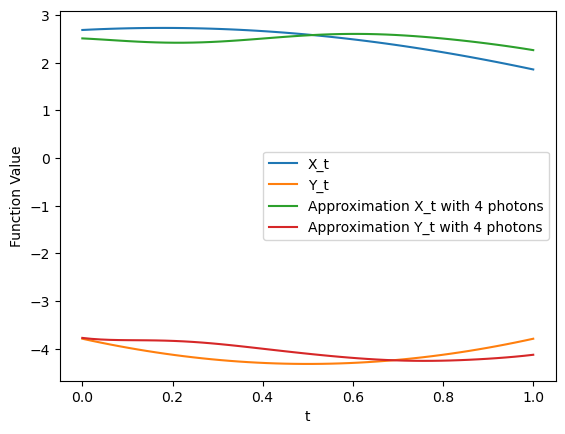

In [18]:
# Generate an array of values for t
T = np.linspace(range_min, range_max, 50)

# Compute the corresponding values of X_t and Y_t
X_values = X_t(T)
Y_values = Y_t(T)

# Plot X_t and Y_t
plt.plot(T, X_values, label='X_t')
plt.plot(T, Y_values, label='Y_t')


# plot_solution(m, N, T, res.x, lambda_random)
plot_solution(m, N, T, res.x, lambda_random)


# Add labels and a legend
plt.xlabel('t')
plt.ylabel('Function Value')
plt.legend()

# Show the plot
plt.show()

In [19]:
# X = np.linspace(range_min, range_max, 200)

# # Change the plot size
# default_figsize = mpl.rcParamsDefault['figure.figsize']
# mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# plot_solution(m, N, X, res.x, lambda_random)

# plt.plot(X, u(X), 'r', label='Analytical solution')
# plt.legend()
# plt.show()

Text(0, 0.5, 'Loss function value')

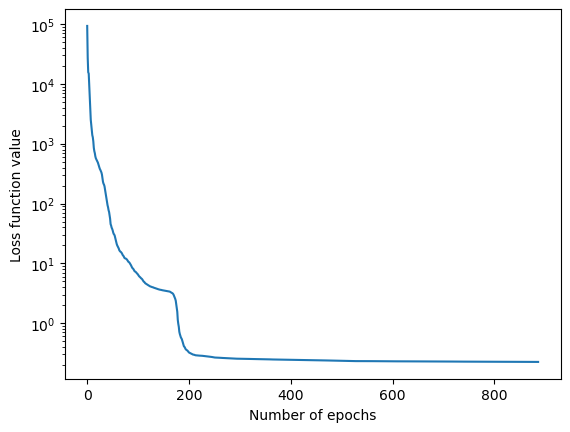

In [20]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")